## From Scratch applying Bayesian Inference, Markov Chain Monte Carlo and Metropolis Hastings and MALA in python

A common technique called Markov Chain Monte Carlo commonly referred to as MCMC. The method stated is a class of techniques for sampling from a probability distribution and can be used to estimate the distribution of parameters given a set of observations.

In [1]:
import numpy as np
import scipy
import scipy.stats
import matplotlib as mpl   
import matplotlib.pyplot as plt
%matplotlib inline

#### Define static function MCMC and appectance rule

In [2]:
#Defines whether to accept or reject the new sample
def acceptance(x, x_new):
    if x_new>x:
        return True
    else:
        accept=np.random.uniform(0,1)
        # Since we did a log likelihood, we need to exponentiate in order to compare to the random number
        # less likely x_new are less likely to be accepted
        return (accept < (np.exp(x_new-x)))

#Define MCMC-Metropolis Hastings
def metropolis_hastings(likelihood_computer,prior, transition_model, param_init,iterations,data,acceptance_rule):
    # likelihood_computer(x,data): returns the likelihood that these parameters generated the data
    # transition_model(x): a function that draws a sample from a symmetric distribution and returns it
    # param_init: a starting sample
    # iterations: number of accepted to generated
    # data: the data that we wish to model
    # acceptance_rule(x,x_new): decides whether to accept or reject the new sample
    x = param_init
    accepted = []
    rejected = []   
    for i in range(iterations):
        x_new =  transition_model(x)    
        x_lik = likelihood_computer(x,data)
        x_new_lik = likelihood_computer(x_new,data) 
        if (acceptance_rule(x_lik + np.log(prior(x)),x_new_lik+np.log(prior(x_new)))):            
            x = x_new
            accepted.append(x_new)
        else:
            rejected.append(x_new)            
                
    return np.array(accepted), np.array(rejected)


### Nomal distribution - function definitions and samples

Step 1. Sample data generation  
Step 2. Formula for finding distirubtion of parameter                   
Step 3. Define PDF and Propsoal Distribution (transition model)            
Step 4. Acceptance or rejection of new parameter

In [3]:
#Normal disturibution functions for sigma paramter.

#The tranistion model defines how to move from sigma_current to sigma_new
transition_model = lambda x: [x[0],np.random.normal(x[1],0.5,(1,))]

def prior(x):
    #x[0] = mu, x[1]=sigma (new or current)
    #returns 1 for all valid values of sigma. Log(1) =0, so it does not affect the summation.
    #returns 0 for all invalid values of sigma (<=0). Log(0)=-infinity, and Log(negative number) is undefined.
    #It makes the new sigma infinitely unlikely.
    if(x[1] <=0):
        return 0
    return 1

#Computes the likelihood of the data given a sigma (new or current) according to equation (2)
def manual_log_like_normal(x,data):
    #x[0]=mu, x[1]=sigma (new or current)
    #data = the observation
    return np.sum(-np.log(x[1] * np.sqrt(2* np.pi) )-((data-x[0])**2) / (2*x[1]**2))

#Same as manual_log_like_normal(x,data), but using scipy implementation. It's pretty slow.
def log_lik_normal(x,data):
    #x[0]=mu, x[1]=sigma (new or current)
    #data = the observation
    return np.sum(np.log(scipy.stats.norm(x[0],x[1]).pdf(data)))


Text(0.5, 1.0, 'Figure 1: Distribution of 1000 observations sampled from a population of 30,000 with mu=10, sigma=3')

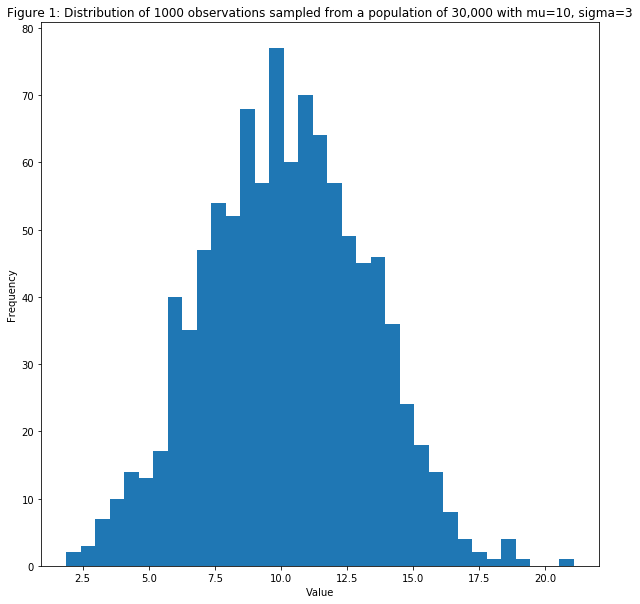

In [4]:
# Normal data gereneration 
mod_normal =lambda t:np.random.normal(10,3,t)

#From a population of 30,000 individual, sample 1000 from relevant distributions
population_size = 30000
sample_size = 1000
population = mod_normal(population_size)
observation = population[np.random.randint(0, population_size, sample_size)]
mu_observed = observation.mean()

#plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.hist( observation,bins=35 ,)
ax.set_xlabel("Value")
ax.set_ylabel("Frequency")
ax.set_title("Figure 1: Distribution of 1000 observations sampled from a population of 30,000 with mu=10, sigma=3")

In [5]:
# Run MCMC on inital paramters and collect/reject samples
accepted, rejected = metropolis_hastings(manual_log_like_normal,prior,transition_model,[mu_observed,0.1], 50000,observation,acceptance)

(8660, 2)

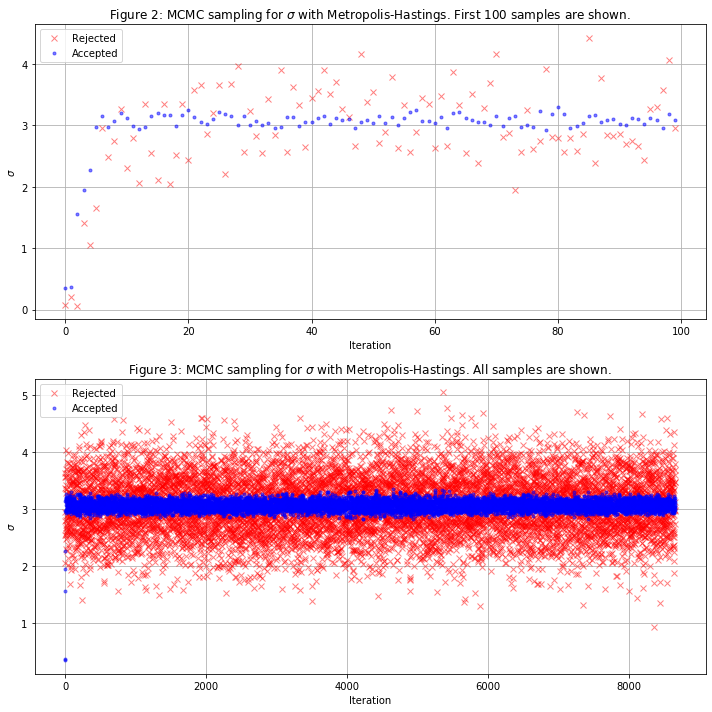

In [8]:
# visualise iterations
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2,1,1)
# show first 100 iterations
ax.plot( rejected[0:100,1], 'rx', label='Rejected',alpha=0.5)
ax.plot( accepted[0:100,1], 'b.', label='Accepted',alpha=0.5)
ax.set_xlabel("Iteration")
ax.set_ylabel("$\sigma$")
ax.set_title("Figure 2: MCMC sampling for $\sigma$ with Metropolis-Hastings. First 100 samples are shown.")
ax.grid()
ax.legend()
# show all iterations
ax2 = fig.add_subplot(2,1,2)
to_show=-accepted.shape[0]
ax2.plot( rejected[to_show:,1], 'rx', label='Rejected',alpha=0.5)
ax2.plot( accepted[to_show:,1], 'b.', label='Accepted',alpha=0.5)
ax2.set_xlabel("Iteration")
ax2.set_ylabel("$\sigma$")
ax2.set_title("Figure 3: MCMC sampling for $\sigma$ with Metropolis-Hastings. All samples are shown.")
ax2.grid()
ax2.legend()

fig.tight_layout()
accepted.shape

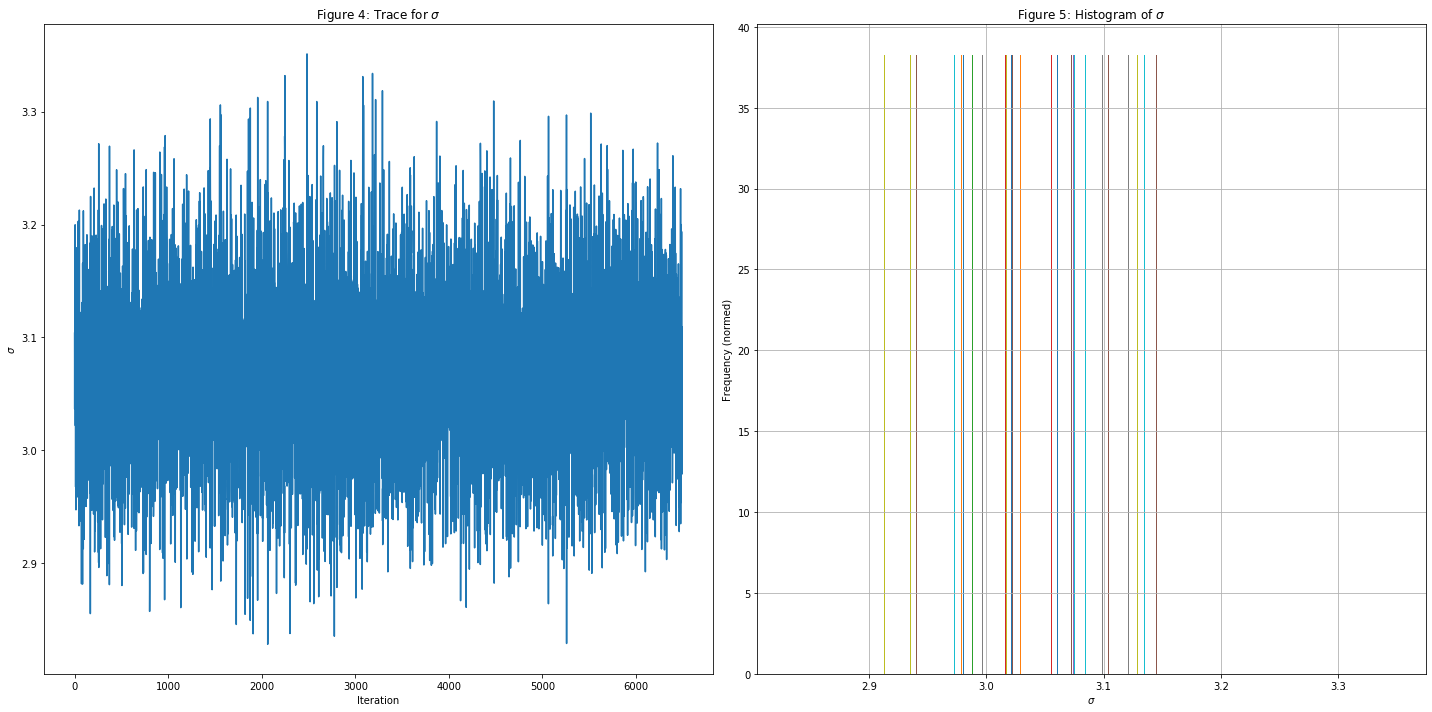

In [10]:
show=int(-0.75*accepted.shape[0])
hist_show=int(-0.75*accepted.shape[0])

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,2,1)
ax.plot(accepted[show:,1])
ax.set_title("Figure 4: Trace for $\sigma$")
ax.set_ylabel("$\sigma$")
ax.set_xlabel("Iteration")
ax = fig.add_subplot(1,2,2)
ax.hist(accepted[hist_show:,1], bins=20,density=True)
ax.set_ylabel("Frequency (normed)")
ax.set_xlabel("$\sigma$")
ax.set_title("Figure 5: Histogram of $\sigma$")
fig.tight_layout()

ax.grid("off")

10.183830221204 [3.06925905]


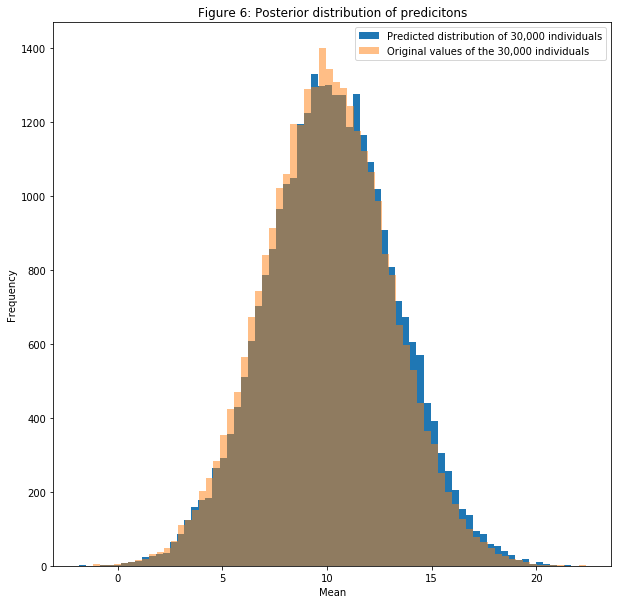

In [9]:
mu=accepted[show:,0].mean()
sigma=accepted[show:,1].mean()
print(mu, sigma)
model = lambda t,mu,sigma:np.random.normal(mu,sigma,t)
observation_gen=model(population.shape[0],mu,sigma)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.hist( observation_gen,bins=70 ,label="Predicted distribution of 30,000 individuals")
ax.hist( population,bins=70 ,alpha=0.5, label="Original values of the 30,000 individuals")
ax.set_xlabel("Mean")
ax.set_ylabel("Frequency")
ax.set_title("Figure 6: Posterior distribution of predicitons")
ax.legend()